#**Data input**

In [ ]:
!unzip data_input4.zip

Archive:  data_input4.zip
replace data_input4/01_healthy/cortex_patient13012020_633nm_obj20_power100_1sec_acc40_сenter2900_place1_20201009_1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras import regularizers
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
import graphviz, pydot, pydotplus
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
root_folder = "data_input4/01_healthy"
healthy = []
for root, dirs, files in os.walk(root_folder):  
    for filename in files:
        healthy.append(filename)

In [ ]:
measurements = []
classifications = []
count_healhy = 0
for sample in healthy:
    df = pd.read_csv(os.path.join(root_folder,sample), sep='\t',skiprows=[0],
        header=None, names=[ 'Wave', 'Intensity'])
    measurements.append(df[['Intensity']].to_numpy())
    classifications.append([1,0])
    count_healhy += 1

print(f'Здоровые ткани: {count_healhy}')

Здоровые ткани: 432


In [ ]:
sick_path = 'image_tumor_patient20022019_633nm_obj20_power100_1sec_сenter2900.txt'
count_sick = 0
df = pd.read_csv(sick_path, sep='\t',skiprows=[0],
    header=None, names=['X', 'Y', 'Wave', 'Intensity'])
for i in range(456):
    measurements.append(df[['Intensity']][i*len(df['Wave'].unique()):(i+1)*len(df['Wave'].unique())].to_numpy())
    classifications.append([0,1])
    count_sick += 1

print(f'Больные ткани: {count_sick}')
print(f'Всего образцов: {count_healhy + count_sick}')

Больные ткани: 456
Всего образцов: 888


In [ ]:
X = np.asarray(measurements)
y = np.asarray(classifications)

In [ ]:
X.shape

(888, 1015, 1)

In [ ]:
X = X.reshape(888, 1015)
X.shape

(888, 1015)

In [ ]:
y.shape

(888, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Total amount of train measurements: (666, 1015)
Total amount of train labels: (666, 2)
Total amount of test measurements: (222, 1015)
Total amount of test labels: (222, 2)


Precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными

Recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

F1 - среднее гармоническое precision и recall

In [ ]:
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# **Let's try stacking some models**:

**LGBM**:  
CV Accuracy = 0.914

**CatBoost**:  
CV Accuracy = 0.920

**XGBoost**:  
CV Accuracy = 0.912  

**Logistic Regression**:  
CV Accuracy = 0.903  

**K Neighbours**:  
CV Accuracy = 0.912  

**Stacking 0.5 * LGBM + 0.5 * Logistic Regression**:  
CV Accuracy = 0.927

**Stacking 0.5 * CatBoost + 0.5 * Logistic Regression**:  
CV Accuracy = 0.918

**Stacking 0.5 * XGBoost + 0.5 * Logistic Regression**:  
CV Accuracy = 0.920

**Stacking 1/3 * (LGBM + LR + KNN)**:  
CV Accuracy = 0.943

**Stacking Neural1(LGBM, LR, KNN)**:  
CV Accuracy = 0.944


**TUNED Stacking 1/3 * (LGBM + LR + KNN)**:  
CV Accuracy = 0.976


In [ ]:
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

from sklearn.base import BaseEstimator


class BoostAndLogisticStack(BaseEstimator):
  def __init__(self, logistic_model_params: dict = None, boosting_model_params: dict = None, verbose: bool = False):
    self.boosting_model = CatBoostClassifier(task_type="GPU", verbose=verbose)
    #self.boosting_model = lgb.LGBMClassifier()
    self.boosting_model_params = boosting_model_params
    #self.boosting_model = xgb.XGBClassifier()
    self.logistic_model = LogisticRegression(max_iter=10000)
    self.logistic_model_params = logistic_model_params
    self.verbose = verbose

  def fit(self, X, y):
    self.boosting_model.fit(X, y)
    self.logistic_model.fit(X, y)
    pass

  def predict(self, X):
    naive_output = (self.boosting_model.predict_proba(X) + self.logistic_model.predict_proba(X)) / 2
    return np.argmax(naive_output, axis=1)


class BoostWrapper(BaseEstimator):
  def __init__(self, model_params: dict = None, verbose: bool = False):
    #self.boosting_model = CatBoostClassifier(task_type="GPU", verbose=False)
    if model_params is None:
      self.boosting_model = lgb.LGBMClassifier()
    else:
      self.boosting_model = lgb.LGBMClassifier(**boosting_model_params)
    self.model_params = model_params
    #self.boosting_model = xgb.XGBClassifier()
    self.verbose = verbose

  def fit(self, X, y):
    self.boosting_model.fit(X, y)
    pass

  def predict(self, X):
    return self.boosting_model.predict(X)


class BoostAndLogisticAndKnnStack(BaseEstimator):
  def __init__(self, logistic_model_params: dict = None, boosting_model_params: dict = None, knn_model_params: dict = None, verbose: bool = False):
    self.boosting_model_params = boosting_model_params
    self.logistic_model_params = logistic_model_params
    self.knn_model_params = knn_model_params

    if self.boosting_model_params == None:
      self.boosting_model = lgb.LGBMClassifier()
    else:
      self.boosting_model = lgb.LGBMClassifier(**self.boosting_model_params)

    if self.logistic_model_params == None:
      self.logistic_model = LogisticRegression(max_iter=10000000)
    else:
      self.logistic_model = LogisticRegression(**self.logistic_model_params)

    if self.knn_model_params == None:
      self.knn_model = KNeighborsClassifier()
    else:
      self.knn_model = KNeighborsClassifier(**self.knn_model_params)
    self.verbose = verbose

  def fit(self, X, y):
    self.boosting_model.fit(X, y)
    self.logistic_model.fit(X, y)
    self.knn_model.fit(X, y)
    pass

  def predict(self, X):
    naive_output = (self.boosting_model.predict_proba(X) + self.logistic_model.predict_proba(X) + self.knn_model.predict_proba(X)) / 3
    return np.argmax(naive_output, axis=1)


class BoostAndLogisticAndKnnStackNeural(BaseEstimator):
  def __init__(self, logistic_model_params: dict = None, boosting_model_params: dict = None, knn_model_params: dict = None, verbose: bool = False, nn_model = None, n_epoch = 10):
    self.boosting_model_params = boosting_model_params
    self.logistic_model_params = logistic_model_params
    self.knn_model_params = knn_model_params

    if self.boosting_model_params == None:
      self.boosting_model = lgb.LGBMClassifier()
    else:
      self.boosting_model = lgb.LGBMClassifier(**self.boosting_model_params)

    if self.logistic_model_params == None:
      self.logistic_model = LogisticRegression(max_iter=100000)
    else:
      self.logistic_model = LogisticRegression(**self.logistic_model_params)

    if self.knn_model_params == None:
      self.knn_model = KNeighborsClassifier()
    else:
      self.knn_model = KNeighborsClassifier(**self.knn_model_params)

    self.verbose = verbose
    self.verbose = verbose
    self.nn_model = nn_model
    self.n_epoch = n_epoch

  def fit(self, X, y):
    self.boosting_model.fit(X, y)
    self.logistic_model.fit(X, y)
    self.knn_model.fit(X, y)

    boosting_proba = self.boosting_model.predict_proba(X)
    logistic_proba = self.logistic_model.predict_proba(X)
    knn_proba = self.knn_model.predict_proba(X)
    train_metafeatures = np.concatenate((boosting_proba, logistic_proba, knn_proba), axis=1)
    #gotta format y to y_neural
    #healthy == [1, 0]
    #sick == [0, 1]
    y_neural = np.empty([y.size, 2])
    i = 0
    for e in y:
      if e == 0:
          y_neural[i] = np.array([1, 0])
      if e == 1:
          y_neural[i] = np.array([0, 1])
      i += 1
    y_neural = y_neural.astype(int)

    self.nn_model.fit(train_metafeatures, y_neural, epochs=self.n_epoch, batch_size=16)
    pass

  def predict(self, X):
    boosting_proba = self.boosting_model.predict_proba(X)
    logistic_proba = self.logistic_model.predict_proba(X)
    knn_proba = self.knn_model.predict_proba(X)
    test_metafeatures = np.concatenate((boosting_proba, logistic_proba, knn_proba), axis=1)
    nn_output = self.nn_model.predict(test_metafeatures)
    prediction = np.argmax(nn_output, axis=1)
    return prediction


In [ ]:
from sklearn.model_selection import cross_validate
skf = StratifiedKFold(n_splits=5, shuffle=True)
y_labels = np.argmax(y, axis=1)
model = BoostAndLogisticAndKnnStack()
#scores = cross_val_score(model, X, y_labels, cv=skf, scoring='accuracy')
results = cross_validate(model, X, y_labels, cv=skf, scoring='accuracy', return_train_score=True)
#np.mean(scores)

In [ ]:
results

{'fit_time': array([12.163625  ,  8.7641418 ,  8.82904768,  8.19262218, 11.38456774]),
 'score_time': array([0.03804445, 0.02906585, 0.04808569, 0.02207088, 0.02222371]),
 'test_score': array([0.9494382 , 0.9494382 , 0.9494382 , 0.92655367, 0.94915254]),
 'train_score': array([0.9971831 , 0.99859155, 0.9971831 , 0.99859353, 0.99859353])}

In [ ]:
np.mean(results['test_score'])

0.9448041642861676

#**Hyperparameter tuning**

In [ ]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define models and parameters
model_lr = LogisticRegression(max_iter=100000000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
grid_search = GridSearchCV(estimator=model_lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X, y_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Best: 0.965099 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.915521 (0.018943) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.908773 (0.016515) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.914378 (0.026388) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.916644 (0.018755) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.908773 (0.018315) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.915508 (0.023183) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.916644 (0.021304) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.920034 (0.018662) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.915508 (0.024780) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.965099 (0.013020) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.918898 (0.019114) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.916638 (0.023280) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.962864 (0.011524) wit

In [ ]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.926770 using {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.924554 (0.010977) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.924554 (0.010977) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.922269 (0.016595) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.920015 (0.016604) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.925652 (0.011078) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.926770 (0.014841) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.915534 (0.017084) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.924535 (0.016209) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.913286 (0.023235) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.918917 (0.016162) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.909916 

In [ ]:
!pip install optuna

In [ ]:
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna

y_labels = np.argmax(y, axis=1)
X_df = pd.DataFrame(X)
y_labels_df = pd.DataFrame(y_labels)

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_df, y_labels)):
        X_train_, X_test_ = X_df.iloc[train_idx], X_df.iloc[test_idx]
        y_train_, y_test_ = y_labels[train_idx], y_labels[test_idx]

        model_boosting = lgb.LGBMClassifier(objective="binary", **param_grid)
        model_boosting.fit(
            X_train_,
            y_train_,
            eval_set=[(X_test_, y_test_)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100
            #callbacks=[
            #    LightGBMPruningCallback(trial, "binary_logloss")
            #],  # Add a pruning callback
        )
        preds_boosting = model_boosting.predict_proba(X_test_)

        model_lr = LogisticRegression(max_iter=10000000, C=0.1, penalty='l2', solver='newton-cg')
        model_lr.fit(X_train_, y_train_)
        preds_lr = model_lr.predict_proba(X_test_)

        model_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=5, weights='distance')
        model_knn.fit(X_train_, y_train_)
        preds_knn = model_knn.predict_proba(X_test_)
        preds = (preds_boosting + preds_lr + preds_knn) / 3
        cv_scores[idx] = log_loss(y_test_, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2023-01-07 20:41:20,689] A new study created in memory with name: LGBM Classifier
/usr/local/lib/python3.8/dist-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[3]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[4]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[5]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[6]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[7]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[8]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[9]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[10]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[11]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[12]	valid_0's binary_logloss: 0.693468	valid_0's binary_logloss: 0.693468
[13]	valid_0's binary_logloss: 0.693468	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[3]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[4]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[5]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[6]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[7]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[8]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[9]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[10]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[11]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[12]	valid_0's binary_logloss: 0.692723	valid_0's binary_logloss: 0.692723
[13]	valid_0's binary_logloss: 0.692723	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

[1]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[3]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[4]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[5]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[6]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[7]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[8]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[9]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[10]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[11]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[12]	valid_0's binary_logloss: 0.693065	valid_0's binary_logloss: 0.693065
[13]	valid_0's binary_logloss: 0.693065	valid_

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

In [ ]:
study.best_params

{'n_estimators': 10000,
 'learning_rate': 0.28660958915468593,
 'num_leaves': 540,
 'max_depth': 7,
 'min_data_in_leaf': 7600,
 'lambda_l1': 65,
 'lambda_l2': 25,
 'min_gain_to_split': 9.955114521669929,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.9}

In [ ]:
par = study.best_params
skf = StratifiedKFold(n_splits=5, shuffle=True)
y_labels = np.argmax(y, axis=1)
model = BoostAndLogisticAndKnnStack(boosting_model_params=par)
#scores = cross_val_score(model, X, y_labels, cv=skf, scoring='accuracy')
results = cross_validate(model, X, y_labels, cv=skf, scoring='accuracy', return_train_score=True)

In [ ]:
results

{'fit_time': array([1.47931051, 1.61140251, 1.61092067, 1.56802011, 0.84831333]),
 'score_time': array([0.02134967, 0.02137995, 0.02135444, 0.02173996, 0.03523898]),
 'test_score': array([0.93258427, 0.93820225, 0.90449438, 0.91525424, 0.94915254]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
np.mean(results['test_score'])

0.9279375357074843

#**Let's try to evaluate tuned model**

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
y_labels = np.argmax(y, axis=1)
model = BoostAndLogisticAndKnnStack()
results = cross_validate(model, X, y_labels, cv=skf, scoring='accuracy', return_train_score=True)

In [ ]:
results

{'fit_time': array([8.27876091, 8.37650156, 8.07955146, 8.11989784, 7.77592921]),
 'score_time': array([0.02586532, 0.02231216, 0.02947664, 0.03370523, 0.02291965]),
 'test_score': array([0.9494382 , 0.92134831, 0.97191011, 0.94915254, 0.89830508]),
 'train_score': array([0.99859155, 0.9971831 , 1.        , 0.99718706, 0.99718706])}

In [ ]:
np.mean(results['test_score'])

0.9380308512664255

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
y_labels = np.argmax(y, axis=1)

# boosting_params = {'n_estimators': 10000,
#  'learning_rate': 0.28660958915468593,
#  'num_leaves': 540,
#  'max_depth': 7,
#  'min_data_in_leaf': 7600,
#  'lambda_l1': 65,
#  'lambda_l2': 25,
#  'min_gain_to_split': 9.955114521669929,
#  'bagging_fraction': 0.9,
#  'bagging_freq': 1,
#  'feature_fraction': 0.9}

boosting_params = {'n_estimators': 10000,
 'learning_rate': 0.15138872524701985,
 'num_leaves': 1640,
 'max_depth': 8,
 'min_data_in_leaf': 200,
 'lambda_l1': 45,
 'lambda_l2': 70,
 'min_gain_to_split': 5.641360966853382,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.5}


logistic_params = {'max_iter' : 10000000, 'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

knn_params = {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

model = BoostAndLogisticAndKnnStack(boosting_model_params=boosting_params, logistic_model_params=logistic_params, knn_model_params=knn_params)
results = cross_validate(model, X, y_labels, cv=skf, scoring='accuracy', return_train_score=True)

In [ ]:
results

{'fit_time': array([21.19780302, 18.72843361, 18.72595739, 19.97530866, 18.93236995]),
 'score_time': array([0.05445218, 0.02847314, 0.02896404, 0.02561402, 0.04682851]),
 'test_score': array([0.98876404, 0.97752809, 0.98314607, 0.97175141, 0.96045198]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
np.mean(results['test_score'])

NameError: ignored

# **Let's try to add a neural layer**:

In [ ]:
#model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
skf = StratifiedKFold(n_splits=4, shuffle=True)
y_labels = np.argmax(y, axis=1)

#model 1
nn_model = Sequential()
nn_model.add(Dense(8, input_shape=(6,), activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(2, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

boosting_params = {'n_estimators': 10000,
 'learning_rate': 0.15138872524701985,
 'num_leaves': 1640,
 'max_depth': 8,
 'min_data_in_leaf': 200,
 'lambda_l1': 45,
 'lambda_l2': 70,
 'min_gain_to_split': 5.641360966853382,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.5}


logistic_params = {'max_iter' : 100000, 'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

knn_params = {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

model = BoostAndLogisticAndKnnStackNeural(nn_model=nn_model, n_epoch=45, boosting_model_params=boosting_params, logistic_model_params=logistic_params, knn_model_params=knn_params)
results = cross_validate(model, X, y_labels, cv=skf, scoring='accuracy', return_train_score=True)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Epoch 1/45
42/42 [==============================] - 3s 3ms/step - loss: 0.5764 - accuracy: 1.0000
Epoch 2/45
42/42 [==============================] - 0s 3ms/step - loss: 0.4509 - accuracy: 1.0000
Epoch 3/45
42/42 [==============================] - 0s 3ms/step - loss: 0.3172 - accuracy: 1.0000
Epoch 4/45
42/42 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 1.0000
Epoch 5/45
42/42 [==============================] - 0s 3ms/step - loss: 0.1244 - accuracy: 1.0000
Epoch 6/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0762 - accuracy: 1.0000
Epoch 7/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 1.0000
Epoch 8/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0316 - accuracy: 1.0000
Epoch 9/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0219 - accuracy: 1.0000
Epoch 10/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 11/45
42/42 [

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Epoch 1/45
42/42 [==============================] - 1s 3ms/step - loss: 0.5772 - accuracy: 1.0000
Epoch 2/45
42/42 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 1.0000
Epoch 3/45
42/42 [==============================] - 0s 3ms/step - loss: 0.3223 - accuracy: 1.0000
Epoch 4/45
42/42 [==============================] - 0s 3ms/step - loss: 0.2108 - accuracy: 1.0000
Epoch 5/45
42/42 [==============================] - 0s 3ms/step - loss: 0.1312 - accuracy: 1.0000
Epoch 6/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 1.0000
Epoch 7/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 1.0000
Epoch 8/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0343 - accuracy: 1.0000
Epoch 9/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 1.0000
Epoch 10/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 1.0000
Epoch 11/45
42/42 [

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Epoch 1/45
42/42 [==============================] - 1s 4ms/step - loss: 0.5750 - accuracy: 1.0000
Epoch 2/45
42/42 [==============================] - 0s 3ms/step - loss: 0.4492 - accuracy: 1.0000
Epoch 3/45
42/42 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 1.0000
Epoch 4/45
42/42 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 1.0000
Epoch 5/45
42/42 [==============================] - 0s 3ms/step - loss: 0.1245 - accuracy: 1.0000
Epoch 6/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0763 - accuracy: 1.0000
Epoch 7/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0480 - accuracy: 1.0000
Epoch 8/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 1.0000
Epoch 9/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0220 - accuracy: 1.0000
Epoch 10/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 1.0000
Epoch 11/45
42/42 [

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

Epoch 1/45
42/42 [==============================] - 1s 3ms/step - loss: 0.5759 - accuracy: 1.0000
Epoch 2/45
42/42 [==============================] - 0s 3ms/step - loss: 0.4498 - accuracy: 1.0000
Epoch 3/45
42/42 [==============================] - 0s 3ms/step - loss: 0.3167 - accuracy: 1.0000
Epoch 4/45
42/42 [==============================] - 0s 3ms/step - loss: 0.2033 - accuracy: 1.0000
Epoch 5/45
42/42 [==============================] - 0s 3ms/step - loss: 0.1241 - accuracy: 1.0000
Epoch 6/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 1.0000
Epoch 7/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 1.0000
Epoch 8/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0314 - accuracy: 1.0000
Epoch 9/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 1.0000
Epoch 10/45
42/42 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 11/45
42/42 [

In [ ]:
results

{'fit_time': array([27.72906375, 23.87133932, 23.33851194, 26.57362437]),
 'score_time': array([0.21316743, 0.17258048, 0.17226672, 0.167027  ]),
 'test_score': array([0.95495495, 0.95495495, 0.97297297, 0.97747748]),
 'train_score': array([1., 1., 1., 1.])}

In [ ]:
np.mean(results['test_score'])

0.9650900900900901

In [ ]:
from joblib import dump, load
#self.boosting_model = lgb.LGBMClassifier()
#self.logistic_model = LogisticRegression(max_iter=10000)
#self.knn_model = KNeighborsClassifier()
#self.verbose = verbose
#self.nn_model = nn_model
dump(model.boosting_model, 'boosting_weights.joblib') 
dump(model.logistic_model, 'logistic_weights.joblib')
dump(model.knn_model, 'knn_weights.joblib')
model.nn_model.save('nn_weights')

In [ ]:
#let's try to find best num_epochs for model 3
from keras.layers import Dropout
nums = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
train_results = []
test_results = []
for n in nums:
  train_acc = 0
  test_acc = 0
  for j in range(3):
    nn_model = Sequential()
    nn_model.add(Dense(8, input_shape=(6,), activation='relu'))
    nn_model.add(Dense(16, activation='relu'))
    nn_model.add(Dropout(0.1))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(16, activation='relu'))
    nn_model.add(Dropout(0.1))
    nn_model.add(Dense(8, activation='relu'))
    nn_model.add(Dense(2, activation='sigmoid'))
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    model = BoostAndLogisticAndKnnStackNeural(nn_model=nn_model, n_epoch=n)
    results = cross_validate(model, X, y_labels, cv=skf, scoring='accuracy', return_train_score=True)

    train_acc += np.mean(results['train_score'])
    test_acc += np.mean(results['test_score'])
  train_acc /= 3
  test_acc /= 3
  train_results.append(train_acc)
  test_results.append(test_acc)

Выходные данные были обрезаны до нескольких последних строк (5000).
10/10 [==============================] - 0s 5ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 30/70
10/10 [==============================] - 0s 6ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 31/70
10/10 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 32/70
10/10 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 33/70
10/10 [==============================] - 0s 5ms/step - loss: 0.0064 - accuracy: 0.9983
Epoch 34/70
10/10 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 0.9983
Epoch 35/70
10/10 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.9983
Epoch 36/70
10/10 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 37/70
10/10 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 38/70
10/10 [==============================] - 

In [ ]:
print(train_results)
print(test_results)


#ffffggg

[0.9932432432432433, 0.9984984984984985, 0.9996246246246246, 0.9998123123123124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9271771771771772, 0.9241741741741741, 0.9301801801801801, 0.9481981981981983, 0.9226726726726727, 0.9256756756756755, 0.9283033033033034, 0.9376876876876876, 0.9335585585585585, 0.9271771771771773, 0.9260510510510511, 0.9102852852852852, 0.9283033033033034, 0.9196696696696697, 0.9324324324324325, 0.9106606606606608]


In [ ]:
np.max(test_results)
np.argmax(test_results)

3

In [ ]:
#model 1
nn_model = Sequential()
nn_model.add(Dense(8, input_shape=(6,), activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(2, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Signal processing magic**

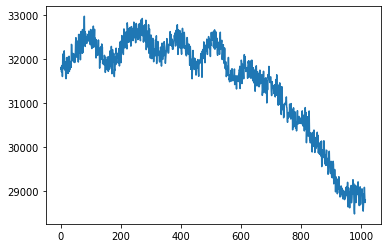

In [ ]:
plt.plot(X_train[20])
plt.show()

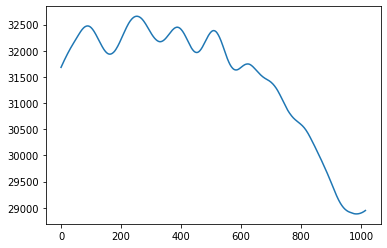

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(X_train[20], 101, 2)
plt.plot(w)  # high frequency noise removed
plt.show()

Savitzky-Golay filter (Фильтр Савицки-Голея) - фильтр для сглаживания данных. Параметр window_length - нечетное число, чем больше чем сглаженне данные

Аналоги которые можно попробовать: Kalman filter, IIR filter, LOWESS 

*   Kalman filter
*   IIR filter
*   LOWESS (Locally Weighted Scatterplot Smoothing)
*   rolling mean
*   RBF (radial basis function) interpolation

In [ ]:
from scipy.signal import savgol_filter
for i in range(len(X_train)):
    X_train[i] = savgol_filter(X_train[i], 101, 2)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
model_catboost = CatBoostClassifier(verbose=False)
model_catboost.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost.predict(X_test))}')
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost.predict(X_test))}')

CatBoost F1 Score 0.9184549356223176
CatBoost Accuracy 0.9144144144144144


In [ ]:
!pip install tsmoothie

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Total amount of train measurements: (666, 1015)
Total amount of train labels: (666, 2)
Total amount of test measurements: (222, 1015)
Total amount of test labels: (222, 2)


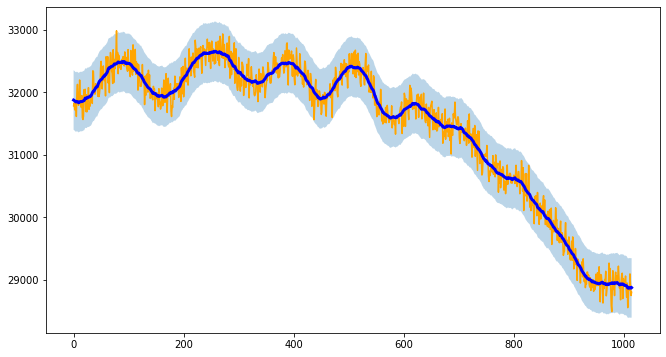

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(X_train)

# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

plt.figure(figsize=(11,6))
plt.plot(smoother.data[20], color='orange')
plt.plot(smoother.smooth_data[20], linewidth=3, color='blue')
plt.fill_between(range(len(smoother.data[20])), low[20], up[20], alpha=0.3)

In [ ]:
# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(X_train)
X_train = smoother.smooth_data

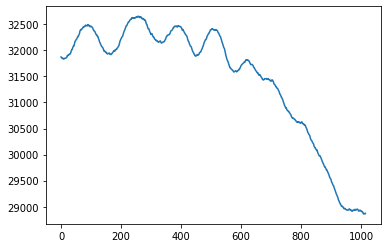

In [ ]:
plt.plot(X_train[20])

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from catboost import CatBoostClassifier
model_catboost3 = CatBoostClassifier(verbose=False)
model_catboost3.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost3.predict(X_test))}')
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost3.predict(X_test))}')

CatBoost F1 Score 0.9184549356223176
CatBoost Accuracy 0.9144144144144144


---
Вывод #2:

---
Neural Network Train: loss: 0.2720 - accuracy: 0.8754 - f1: 0.8715

CatBoost: Accuracy 0.925 F1 Score 0.93

---
After noise removed Savitzky-Golay filter:

---
Neural Network Train: loss: 0.2534 - accuracy: 0.8724 - f1: 0.8689

CatBoost: Accuracy 0.92 F1 Score 0.91

---
After noise removed ConvolutionSmoother:

---
Neural Network Train: loss: loss: 0.2582 - accuracy: 0.8754 - f1: 0.8868

CatBoost: Accuracy 0.92 F1 Score 0.91

---
Сглаживание не дало большого результата